# Introduction to nonlinear elasticity: deflection of a heavy hyperelastic beam

In this notebook we give an example for the solution of a problem in nonlinear elasticity. We study a cantilever beam loaded by its own weigth

We exploit UFL features for automatic symbolic differentiation and formulate the problem in terms of the potential energy of the system.

We will use here the dolfinx build-in nonlinear Netwon solver to solve the problem.

This notebook is adapted from the tutorial https://jorgensd.github.io/dolfinx-tutorial/chapter2/hyperelasticity.html (in 3D).

Please complete the code and answear questions (these questions here and there in the code are typical questions that we could ask you during the final oral exam).

![image of beam](schema_non_lin_beam.png "Nonlinear Cantilever")

## Basic import statements and parameters

In [1]:
import dolfinx 
from dolfinx import nls
import matplotlib.pyplot as plt
import ufl 
import numpy as np
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import pyvista
import extract

## Problem and solver setting
Create a mesh and the `ds` measures with boundary indicators.

In [2]:
# geometry and mesh 
L = 1. # total length # Question: why do we set L=1, what are the units used in this code?
d = L/10. # thickness
h = d/6. # size of a cell # Question: how many cells are there in the mesh?

my_domain = dolfinx.mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, -0.5*d), (L, 0.5*d)), n=(int(L/h), int(d/h)),
                            cell_type=dolfinx.mesh.CellType.triangle)

# Save the mesh in XDMF format
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/mesh.xdmf", "w") as file:
    file.write_mesh(my_domain)
    my_domain.topology.create_connectivity(1, 2)

In [3]:
def left(x): # Question: what does this function return? A real, an Array, or a boolean?
    return np.isclose(x[0], 0)

def right(x):
    return np.isclose(x[0], L)

fdim = my_domain.topology.dim -1
left_facets = dolfinx.mesh.locate_entities_boundary(my_domain, fdim, left)
right_facets = dolfinx.mesh.locate_entities_boundary(my_domain, fdim, right)

# Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with 2
marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full_like(left_facets, 1), np.full_like(right_facets, 2)])
sorted_facets = np.argsort(marked_facets) # Question: what information is in this array?
# Question: what is this array: marked_facets[sorted_facets]?
facet_tag = dolfinx.mesh.meshtags(my_domain, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

# all this was to create the measure ds, to be able to obtain information on the free end of the cantilever
ds = ufl.Measure('ds', domain=my_domain, subdomain_data=facet_tag)
dx = ufl.Measure("dx", domain=my_domain)

We can plot the mesh using ```pyvista``` *(optional)*.

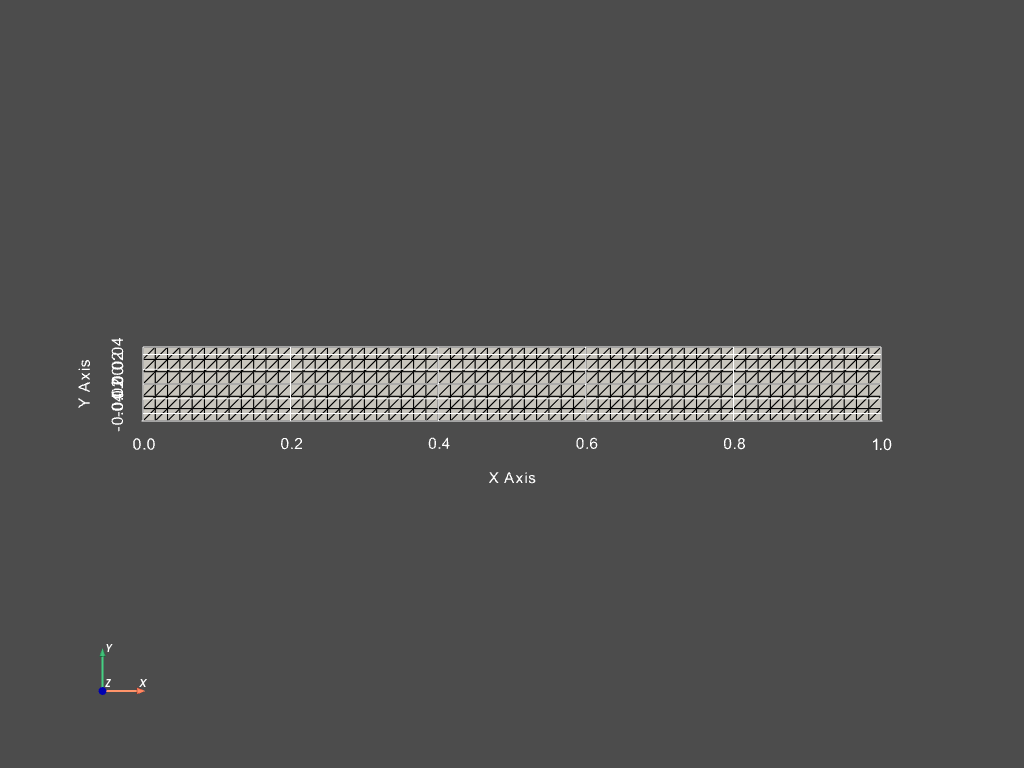

In [4]:
topology, cell_types, geometry_for_plotting = dolfinx.plot.create_vtk_mesh(my_domain, 2)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry_for_plotting)

pyvista.set_jupyter_backend("none")

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show_axes()
plotter.show_bounds(grid='front', location='outer', all_edges=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    figure = plotter.screenshot("fundamentals_mesh.png")

 We define now the finite element space for the displacement ```u```.

In [5]:
V = dolfinx.fem.VectorFunctionSpace(my_domain, ("CG", 2))
u = dolfinx.fem.Function(V)

Let us introduce now some useful definition for the kinematics. These expresions are symbolic operators of ```UFL```. At this level no computation is performed.

In [6]:
# Spatial dimension
dim = len(u)

# Identity tensor
I = ufl.variable(ufl.Identity(dim))

# Deformation gradient
F = ufl.variable(I + ufl.grad(u))

# Right Cauchy-Green tensor
C = ufl.variable(F.T * F)

# Green-Lagrange strain
E = ufl.variable(1/2*(C-I))

We define the elastic energy density with the Kirchhoff Saint-Venant model where:
$$
\psi(E) = (\lambda/2)(\text{tr}(E))^2 + \mu \,E:E
$$

In [7]:
# Stored strain energy density
# Elasticity parameters (plane-stress)
Y = 1.0 # Question: what unit of pressure have we just chosen?
nu = 0.3
mu = Y/(2*(1 + nu))
lmbda = Y*nu/((1 + nu)*(1 - 2*nu))
lmbda2D = 2*lmbda*mu/(lmbda + 2*mu) 
psi = lmbda*ufl.tr(E)**2/2+mu*ufl.inner(E,E)

Hence, we can define the bulk force ($b_0=\rho \, g$) and the total potential energy functional. The bulk force is initially set to 0.


In [8]:
rhog = dolfinx.fem.Constant(my_domain, ScalarType((0, 0)))
potential_energy = psi*dx - ufl.inner(u, rhog)*dx #Question : what is the meaning of the second term?
# Is there a shear load at the end of the cantilever ?

As a Dirichlet Boundary condition, we block the left-end.

In [9]:
left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(1))
#Question: what is the difference between facet_tag.find(1) and facet_tag.find(2)?
u_bc = np.array((0,0), dtype=ScalarType)
bc = dolfinx.fem.dirichletbc(u_bc, left_dofs,V)

The variational problem to solve is the minimization of the potential energy with the given boundary conditions. To this end we need to define the  *residual*, given by the first derivative of the energy.

In FEniCS, thanks to the symbolic differentiation tools provided by `UFL` this can be done automatically, without effort from the user.

To this end we use the `derivative` function from `UFL` which allows us to calculate the directional derivative of a form. We refer to the `UFL` manual for the syntax: https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#ad


In [10]:
v = ufl.TestFunction(V)
residual = ufl.derivative(potential_energy, u, v)

All the informations about the variational problem to be solved  (residual, bcs and indipendent variable) can be  collected in the class `NonlinearProblem`.

In [11]:
problem = dolfinx.fem.petsc.NonlinearProblem(residual, u, bcs=[bc])

The problem is nonlinear and requires the use of an iterative solver, here we use the Newton method. 

We create a solver in the nonlinear solver class. This solver can implement the basic newton method or more complex nonlinear solvers (that we will not discuss in class). A long list of parameters can be specified. All the nonlinear solver available in PETSc can be used. We suggest the reading of the PETSC user manual (Chapter 5, SNES Solver). 

In [12]:
solver = nls.petsc.NewtonSolver(my_domain.comm, problem)
# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

We use the ```plot_function_u``` from the tutorial https://jorgensd.github.io/dolfinx-tutorial/chapter2/hyperelasticity.html *(optional)*.

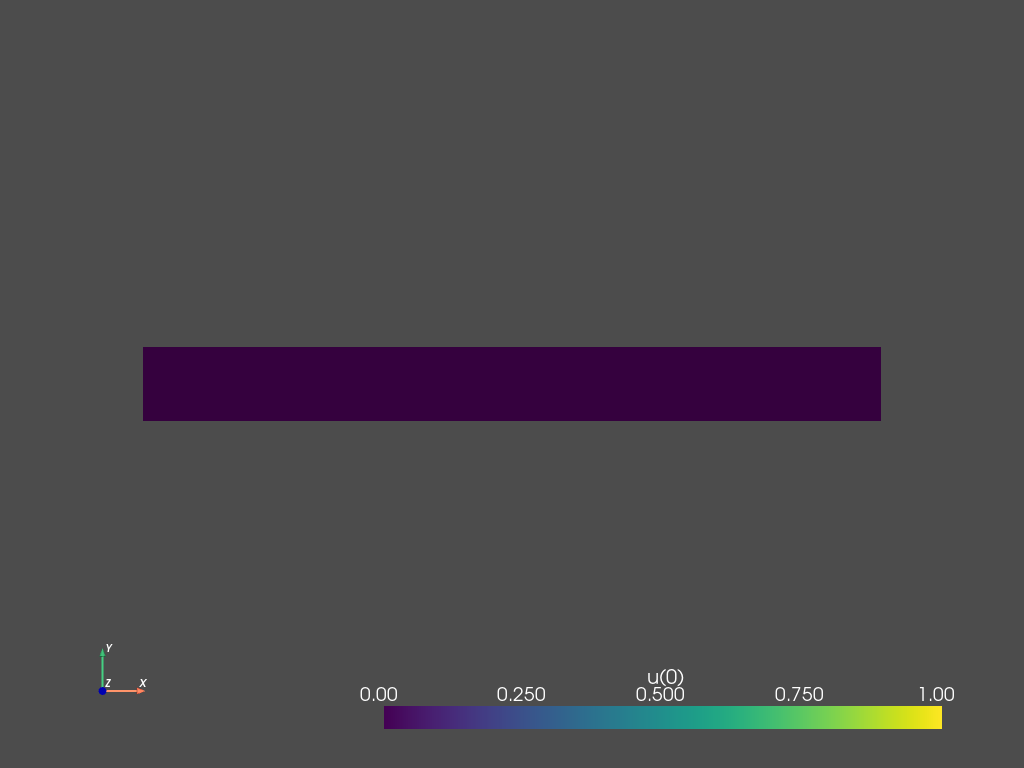

In [13]:
pyvista.set_jupyter_backend("none")
grid = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(my_domain, my_domain.topology.dim))

def plot_function_u(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter()
    # Create grid defined by the function space for visualization of the function
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(uh.function_space)
    function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
    var_name = f"u({t})"
    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(uh)] = uh.x.array.reshape(geometry.shape[0], len(uh))
    function_grid[var_name] = values
    function_grid.set_active_vectors(var_name)
    # Warp mesh by deformation
    warped = function_grid.warp_by_vector(var_name, factor=1)
    
    # Add mesh to plotter and visualize
    actor = p.add_mesh(warped)
    p.show_axes()
    p.view_xy()
    if not pyvista.OFF_SCREEN:
        p.show()
    else:
        pyvista.start_xvfb()
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)

plot_function_u(0, u)

## Solve the static nonlinear problem
We can now solve the problem for vanishing loads. By default the solution is initialized at $u=(0,0)$.
Without surprise the solution is null because the loading is null. The solver gives the output: the number of newton iterations required and the reason (1: converged, 0: non-converged).

We can then increase sligtly the volume force. 

2022-11-03 20:01:51.571 (  34.806s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-11-03 20:01:51.989 (  35.224s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-11-03 20:01:52.022 (  35.256s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.198275 (tol = 1e-08) r (rel) = 0.0711496(tol = 1e-08)
2022-11-03 20:01:52.029 (  35.263s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-11-03 20:01:52.057 (  35.291s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 0.00530964 (tol = 1e-08) r (rel) = 0.00190532(tol = 1e-08)
2022-11-03 20:01:52.061 (  35.296s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-11-03 20:01:52.082 (  35.316s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iter

number of iterations in Newton solver: 6


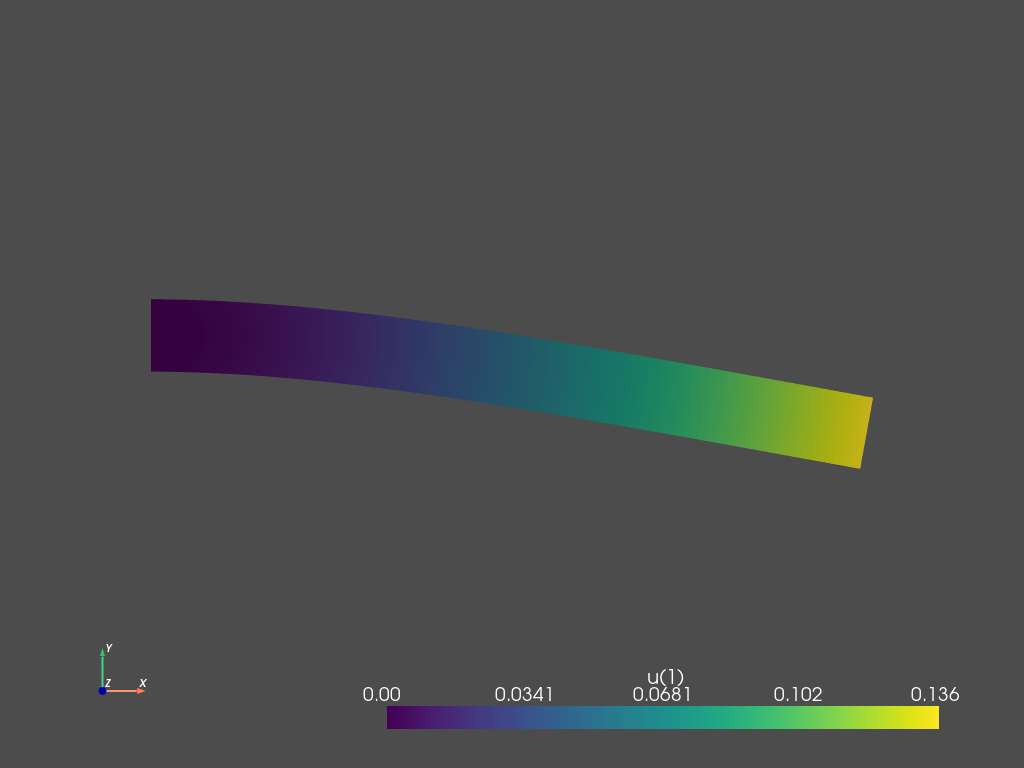

In [14]:
from dolfinx import log
log.set_log_level(log.LogLevel.INFO)
u.x.set(0) # Question: what does this command do?
rhog.value[1] = -0.001
niterations, reason = solver.solve(u)
print('number of iterations in Newton solver:',niterations)
plot_function_u(1, u)

We get a reasonable solution, showing the deflection of the beam under its own weight. 
As a quantitative output we can print the vertical displacement at the rigth end (using ```extract``` or ```assemble```).

In [23]:
extract.solution(my_domain, u, 0.999, 0.0001)[1]

0.0

In [15]:
dolfinx.fem.assemble_scalar(dolfinx.fem.form(u[1]*ds(2)))/d

2022-11-03 20:02:02.435 (  45.670s) [main            ]topologycomputation.cpp:786   INFO| Requesting connectivity 1 - 2
2022-11-03 20:02:02.435 (  45.670s) [main            ]topologycomputation.cpp:786   INFO| Requesting connectivity 2 - 1
2022-11-03 20:02:02.435 (  45.670s) [main            ]topologycomputation.cpp:786   INFO| Requesting connectivity 1 - 2
2022-11-03 20:02:02.435 (  45.670s) [main            ]topologycomputation.cpp:786   INFO| Requesting connectivity 2 - 1


-0.1354150336796363

We can also plot the displacement along the midline $(y=0)$ using ```matplotlib``` (see TP1).

In [ ]:
tol = 0.001 # Avoid hitting the outside of the domain
nbr_pts = 20 # number of plot points
liste_x = np.linspace(0 + tol, L - tol, nbr_pts) # I will plot for x in (0;1)
liste_y = 0*liste_x # It will plot for y = 0

liste_uy=[]
for i, x_i in enumerate(liste_x):
    y_i=liste_y[i]
    usol=extract.solution(my_domain, u, x_i, y_i)
    liste_uy.append(usol[1])

fig = plt.figure()
plt.plot(liste_x, liste_uy, "o", linewidth=2, label="u_y(x,0)")
plt.grid(True)
plt.xlabel("x")
plt.xlim((0.,1.))
plt.ylim((-1.,0.2))
plt.axis('equal')
plt.ylabel("u_y(x,0)")
plt.title("Vertical displacement of the beam neutral axis")
plt.legend()
plt.show()

We can calculate the total reaction force at the left end, we can have an automatic symbolic derivation of the strain energy density to define the First Piola-Kirchhoff stress 
 
 $${P}=\dfrac{\partial\Psi}{\partial F}$$
 
 To this end we use the `diff` operator in `UFL`(https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html#variable-derivatives).
 
 Its use requires to define the symbol of the derivation variable as a `UFL` `variable`. 
 That is the reason why `F` in the previous cell is defined as a `ufl.variable`.

In [17]:
P = ufl.diff(psi, F)

We can convert ```P``` to an ```Expression``` and interpolate it on our mesh. 

In [18]:
# Question: what is the natural function space for P? (given u is CG2)
W = dolfinx.fem.TensorFunctionSpace(my_domain, ("DG", 1)) # Question: what are the dimensions of this tensor?
P_expr = dolfinx.fem.Expression(P, W.element.interpolation_points())
P_h = dolfinx.fem.Function(W)
P_h.interpolate(P_expr)
with dolfinx.io.XDMFFile(my_domain.comm, "output/solution_P.xdmf", "w") as file:
    file.write_mesh(my_domain)
    file.write_function(P_h)

We can then print ```P``` at the left end of the cantilever, note that this tensor is not symmetric.

In [19]:
extract.solution(my_domain, P_h, 0.0, 0.01)
# Question: why do we have 4 numbers?
# Question: is P symetric?

array([0., 0., 0., 0.])

Next, we adapt the ```plot_function``` from the tutorial to visualize the components of ```P``` *(optional)*.

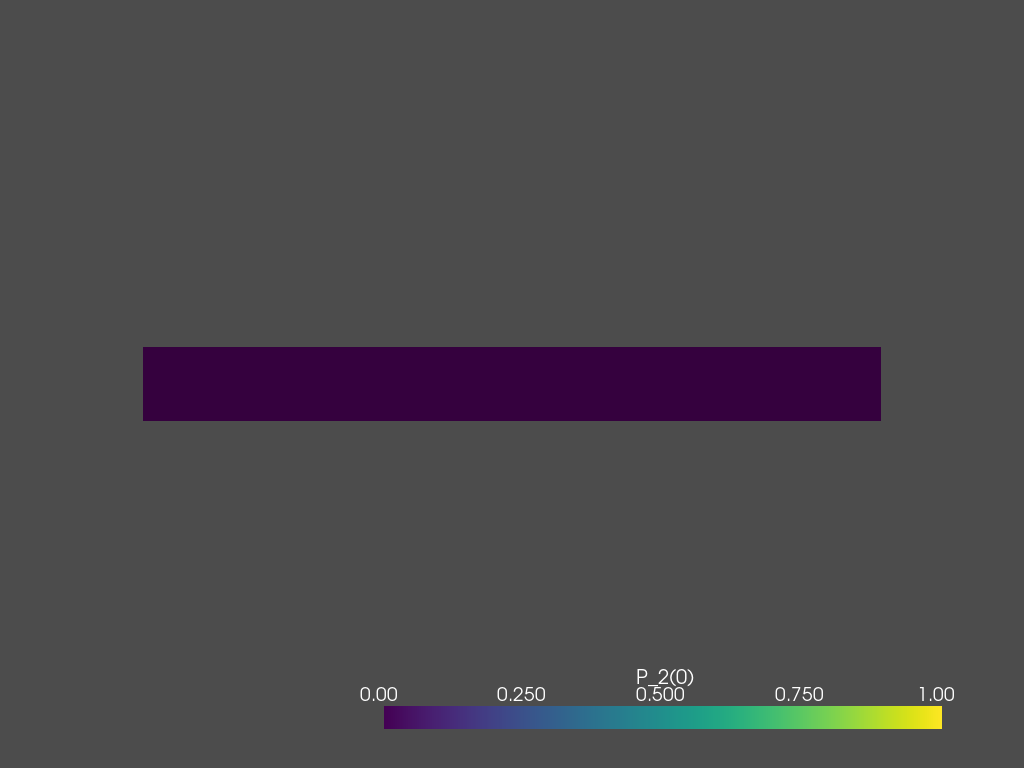

In [20]:
def plot_function_P(t, Ph, i):
    p = pyvista.Plotter()
    # Create grid defined by the function space for visualization of the function
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(Ph.function_space)
    function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
    var_name_P = f"P_{i}({t})"
    values_P = np.zeros((geometry.shape[0], 3))
    values_P[:, :1] = Ph.x.array.reshape(geometry.shape[0], 4)[:,[i]]
    function_grid[var_name_P] = values_P
    function_grid.set_active_vectors(var_name_P)
    actor = p.add_mesh(function_grid)
    #p.show_axes()
    p.view_xy()
    if not pyvista.OFF_SCREEN:
        p.show()
    else:
        pyvista.start_xvfb()
        p.remove_actor(actor)

plot_function_P(0, P_h, 2)

We can calculate the total reaction force at the left end to double-check against what we expect from global equilibrium.

In [21]:
fL1 = dolfinx.fem.assemble_scalar(dolfinx.fem.form(P_h[0,0]*ds(1)))
fL2 = dolfinx.fem.assemble_scalar(dolfinx.fem.form(P_h[1,0]*ds(1)))
print(fL1,fL2)

0.0 0.0


In [22]:
fL1_theo = dolfinx.fem.assemble_scalar(dolfinx.fem.form(rhog[0]*dx))
fL2_theo = dolfinx.fem.assemble_scalar(dolfinx.fem.form(rhog[1]*dx))
print(fL1_theo,fL2_theo)
print("Errors: ",(fL1-fL1_theo),(fL2-fL2_theo)/fL2_theo)

0.0 0.0


ZeroDivisionError: float division by zero

The error is non-negligible (especially if we are in the nonlinear regime). 
- Convergence toward the expected value can be obtained after mesh refinement or increasing the interpolation order of the basis functions. 
- You can check also that the error will be large with linear elements. The presence of body loading renders linear elements non optimal. Is there an explanation for this? 

# Question: is the force zero at the right end of the beam? Is this correct?

## Solve of a quasi-static evolution problem with continuation

We now increment the loading slowly. 
We discretize the total applied load into $n_t$ load-steps of equal length. 
At each load step $t_i$, the solution of the problem can be obtained by initializing the newton solver  with the solution of the previous load-step. This will greatly facilitate the convergence of the Newton algorithm. 

It is sufficient to perform a `for` loop as follows. Note the initialization of the Newton algorithm at each load-step is done with the latest solution available which is stored in memory.


*Remark:* 
- The initialization of the solution before starting the solver is fundamental in nonlinear problems, because the solution can be not unique. 

- Smaller load-steps generally helps convergence. Nonlinear solves can not converge for large load-steps because the initialization of the newton solver is not close enough to a possible solution.

- Newton solvers converge very quickly (quadratic convergence rate) when they are close to a possible solution of the system to solve. But they can stagnate or diverge is they are not correctly initialized. 

- You can monitor the interation of the Newton solver in the terminal window where you launched `jupyter`.

You can play to test these points.


In [ ]:
from dolfinx import log
log.set_log_level(log.LogLevel.INFO) # The code reports several information
# log.set_log_level(log.LogLevel.ERROR) # The code only reports errors
loads = np.linspace(0, 0.01, 10)
displ = np.zeros(10)
u.x.set(0)
with dolfinx.io.XDMFFile(my_domain.comm, "output/solution.xdmf", "w") as file:
    file.write_mesh(my_domain)
for (i, t) in enumerate(loads):
    rhog.value[1] = -t
    num_its, converged = solver.solve(u)
    with dolfinx.io.XDMFFile(my_domain.comm, "output/solution.xdmf", "a") as file:
        file.write_function(u, t)
    displ[i] = dolfinx.fem.assemble_scalar(dolfinx.fem.form(u[1]*ds(2)))/d
    assert(converged)
    u.x.scatter_forward()
    print(f"Time step {i}, Number of iterations Newton {num_its}, Load {rhog.value}, displ {displ[i]}")
    plot_function_u(i, u)

In [ ]:
plt.figure(2)
plt.plot(loads,displ, "o")
plt.xlabel("load")
plt.ylabel("end-displacement")

# Wrap up
Let us refactor the nonlinear solver in a function that resume the code required to solve the problem. We can then test it.

In [ ]:
import dolfinx 
from dolfinx import nls
import matplotlib.pyplot as plt
import ufl 
import numpy as np
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import pyvista
import extract

def solve_hyperelasticity(load_max=0.1, nsteps=40, load_min=0, nu=0.3, e=1/6., d=0.1):
    L=1.0
    h = d*e 
    my_domain = dolfinx.mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, -0.5*d), (L, 0.5*d)), n=(int(L/h), int(d/h)),
                            cell_type=dolfinx.mesh.CellType.triangle)
    def left(x):
        return np.isclose(x[0], 0)
    def right(x):
        return np.isclose(x[0], L)
    fdim = my_domain.topology.dim -1
    left_facets = dolfinx.mesh.locate_entities_boundary(my_domain, fdim, left)
    right_facets = dolfinx.mesh.locate_entities_boundary(my_domain, fdim, right)
    marked_facets = np.hstack([left_facets, right_facets])
    marked_values = np.hstack([np.full_like(left_facets, 1), np.full_like(right_facets, 2)])
    sorted_facets = np.argsort(marked_facets)
    facet_tag = dolfinx.mesh.meshtags(my_domain, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])
    ds = ufl.Measure('ds', domain=my_domain, subdomain_data=facet_tag)
    dx = ufl.Measure("dx", domain=my_domain)
    V = dolfinx.fem.VectorFunctionSpace(my_domain, ("CG", 2))
    u = dolfinx.fem.Function(V)
    dim = len(u)
    I = ufl.variable(ufl.Identity(dim))
    F = ufl.variable(I + ufl.grad(u))
    C = ufl.variable(F.T * F)
    E = ufl.variable(1/2*(C-I))
    Y = 1.0
    mu = Y/(2*(1 + nu))
    lmbda = Y*nu/((1 + nu)*(1 - 2*nu))
    lmbda2D = 2*lmbda*mu/(lmbda + 2*mu) 
    psi = lmbda*ufl.tr(E)**2/2+mu*ufl.inner(E,E)
    rhog = dolfinx.fem.Constant(my_domain, ScalarType((0, 0)))
    Text = dolfinx.fem.Constant(my_domain, ScalarType((0, 0)))
    potential_energy = psi*dx - ufl.inner(u, rhog)*dx - ufl.inner(u, Text)*ds(2)
    left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(1))
    u_bc = np.array((0,) * my_domain.geometry.dim, dtype=ScalarType)
    bc = dolfinx.fem.dirichletbc(u_bc, left_dofs,V)
    v = ufl.TestFunction(V)
    residual = ufl.derivative(potential_energy, u, v)
    problem = dolfinx.fem.petsc.NonlinearProblem(residual, u, bcs=[bc])
    solver = nls.petsc.NewtonSolver(my_domain.comm, problem)
    solver.atol = 1e-8
    solver.rtol = 1e-8
    loads = np.linspace(load_min, load_max, nsteps)
    displ = 0.0*loads
    u.x.set(0)
    solver.convergence_criterion = "incremental"

    for (i, t) in enumerate(loads):
        rhog.value[1] = -t
        solver.solve(u)
        displ[i] = dolfinx.fem.assemble_scalar(dolfinx.fem.form(u[1]*ds(2)))/d
        print("t={:+3.3f}, u={:+3.3f}".format(t, displ[i]))
    return (loads,displ)

In [ ]:
loads, displ = solve_hyperelasticity(load_max=0.005,nsteps=40,load_min=0,nu=0.3,e=1/6.,d=0.1)
print(displ)

# Exercice
- Try to increase the maximum loading to rhog = 0.02. Is the Newton solver converging?
- Try to reduce the number of steps to reach the maximum loading. Is the Newton solver converging?
- We introduce the parameter $\Gamma = \frac{Mg}{EI/L^2}$
- For low weight, plot y(L)/L versus $\Gamma$. What is the scaling of this curve?
- For significant weight, draw y(L)/x(L). What is the scaling of this curve?
- Try to replace the elastic energy density with the weakly incompressible Neo-Hookean model where:
$$
\psi(F) = \dfrac{\mu}{2}(\mathrm{tr}(F^T F) - 2) - \mu\ln(\det F) + (\lambda/2)*(\ln(\det F))^2
$$
and perform again the numerical simulation for a loading going form 0 to 0.02. Is the Newton solver converging? 
- We consider a steel beam with L=3 m, h=1 cm sagging under its own weight. What is the value of y(L) in cm ?